In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

import xgboost
import lightgbm as lgb
import missingno
import sklearn
print(xgboost.__version__)
print(lgb.__version__)
print(missingno.__version__)
print(sklearn.__version__)

1.4.2
3.3.0
0.5.0
1.0


In [11]:
random_state=42

In [12]:
data_dir = 'data'

train_data_path = join(data_dir, 'train.csv') # train 데이터 불러오기 
test_data_path = join(data_dir, 'test.csv') # test 데이터 불러오기

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [13]:
y = train['price'] # train에 있는 price는 target값이므로 y에 넣고
del train['price'] # train에서 삭제
del train['id']
del test['id']
print(train.columns)
print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [14]:
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


- date에서 연월만 사용하기 위해 전처리

In [15]:
train['date'] = train['date'].apply(lambda x: x[:6]).astype(int)
test['date'] = test['date'].apply(lambda x: x[:6]).astype(int)

In [16]:
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [17]:
x_train, x_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

In [18]:
y_train = np.log1p(y_train) # target을 log 스케일 해주면 성능이 올라감

In [19]:
x_train.shape, y_train.shape

((12028, 19), (12028,))

In [23]:
def my_RandomSearch(model, train, y, param_dist, verbose=3):
    random_search = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_dist, 
    n_iter=5,  # 5번의 랜덤 검색
    scoring='neg_mean_squared_error',  # 정확도 기준
    cv=3,  # 3겹 교차검증
    verbose=verbose,
    random_state=random_state,
    n_jobs=-1
)
    
    # 모델 fitting
    random_search.fit(train, y)

    # 결과값 저장
    params = random_search.cv_results_['params']
    score = random_search.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSE 값 계산 후 정렬
    results['RMSE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSE')

    return results

In [24]:
xgb_model = xgboost.XGBRegressor(random_state = random_state)
param_dist = {
    'learning_rate': [0.1, 0.5],
    'subsample':[0.7],
    'colsample_bytree':[0.7],
    'n_estimators': [500, 1000, 1500],  # 트리 개수
    'max_depth': [1, 10, 20],  # 트리 깊이
}
xgb_result_df = my_RandomSearch(xgb_model, x_train, y_train, param_dist, verbose=10)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


[CV 1/3; 1/5] START colsample_bytree=0.7, learning_rate=0.1, max_depth=1, n_estimators=500, subsample=0.7
[CV 1/3; 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=1, n_estimators=500, subsample=0.7;, score=-0.039 total time=   4.4s
[CV 3/3; 1/5] START colsample_bytree=0.7, learning_rate=0.1, max_depth=1, n_estimators=500, subsample=0.7
[CV 3/3; 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=1, n_estimators=500, subsample=0.7;, score=-0.039 total time=  14.1s
[CV 2/3; 2/5] START colsample_bytree=0.7, learning_rate=0.1, max_depth=1, n_estimators=1000, subsample=0.7
[CV 2/3; 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=1, n_estimators=1000, subsample=0.7;, score=-0.034 total time=  21.1s
[CV 1/3; 3/5] START colsample_bytree=0.7, learning_rate=0.1, max_depth=20, n_estimators=1500, subsample=0.7
[CV 1/3; 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=20, n_estimators=1500, subsample=0.7;, score=-0.029 total time= 1.6min


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


[CV 2/3; 1/5] START colsample_bytree=0.7, learning_rate=0.1, max_depth=1, n_estimators=500, subsample=0.7
[CV 2/3; 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=1, n_estimators=500, subsample=0.7;, score=-0.037 total time=   5.4s
[CV 1/3; 2/5] START colsample_bytree=0.7, learning_rate=0.1, max_depth=1, n_estimators=1000, subsample=0.7
[CV 1/3; 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=1, n_estimators=1000, subsample=0.7;, score=-0.037 total time=  21.2s
[CV 3/3; 2/5] START colsample_bytree=0.7, learning_rate=0.1, max_depth=1, n_estimators=1000, subsample=0.7
[CV 3/3; 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=1, n_estimators=1000, subsample=0.7;, score=-0.037 total time=  18.0s
[CV 2/3; 3/5] START colsample_bytree=0.7, learning_rate=0.1, max_depth=20, n_estimators=1500, subsample=0.7
[CV 2/3; 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=20, n_estimators=1500, subsample=0.7;, score=-0.027 total time= 1.6min


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


In [25]:
xgb_result_df

,subsample,n_estimators,max_depth,learning_rate,colsample_bytree,score,RMSE
4,0.7,500,10,0.1,0.7,-0.027317,0.165279
3,0.7,1500,10,0.1,0.7,-0.027326,0.165305
2,0.7,1500,20,0.1,0.7,-0.028094,0.167613
1,0.7,1000,1,0.1,0.7,-0.036029,0.189812
0,0.7,500,1,0.1,0.7,-0.038512,0.196244


In [ ]:
# lgb는 n_estimators 하이퍼 파라미터는 별 영향 없는 거 같고 max_depth가 낮을 수록 안 좋음

In [26]:
lgb_model = xgboost.XGBRegressor(random_state = random_state)
param_dist = {
    'learning_rate': [0.1, 0.05],
    'n_estimators' : [500,1000],
    'max_depth': [1, 5, 15],  # 트리 깊이     
}
lgb_result_df = my_RandomSearch(lgb_model, x_train, y_train, param_dist, verbose=10)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [27]:
lgb_result_df

,n_estimators,max_depth,learning_rate,score,RMSE
1,1000,5,0.05,-0.026736,0.163510
3,500,5,0.05,-0.027029,0.164406
0,500,15,0.05,-0.028252,0.168083
4,1000,15,0.10,-0.028699,0.169409
2,500,1,0.10,-0.038961,0.197386


In [66]:
# lbg는 n_estimatros가 커지는 경향에 max_depth는 5정도로, LR은 0.05,
# 다른 하이퍼 파라미터가 영향이 없는거 같아서 subsample과 colsample을 살짝 조정할 필요성 있어보임

In [64]:
xgb_model = xgboost.XGBRegressor(random_state = random_state, 
                                 learning_rate = 0.05, subsample = 0.5, 
                                 n_estimators = 1000,
                                 max_depth = 10, 
                                 colsample_bytree=0.5)
xgb_model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=2, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [56]:
lgb_model = lgb.LGBMRegressor(random_state = random_state, learning_rate=0.05, max_depth=5, n_estimators=1500)
lgb_model.fit(x_train, y_train)

LGBMRegressor(learning_rate=0.05, max_depth=5, n_estimators=1500,
              random_state=42)

In [65]:
# 모델 2개 예측값의 평균을 최종 예측값으로 사용
xgb_pred = xgb_model.predict(x_test)
xgb_pred = np.expm1(xgb_pred)
lgb_pred = lgb_model.predict(x_test)
lgb_pred = np.expm1(lgb_pred)
average_pred = 0.5 * xgb_pred + 0.5*lgb_pred
print('xgb_rmse : ', np.sqrt(mean_squared_error(y_test, xgb_pred)))
print('lgb_rmse : ', np.sqrt(mean_squared_error(y_test, lgb_pred)))
print('average_rmse : ', np.sqrt(mean_squared_error(y_test, average_pred)))

xgb_rmse :  114116.93344195191
lgb_rmse :  114405.32520166048
average_rmse :  111637.38148862855


In [67]:
xgb_test = xgb_model.predict(test)
xgb_test = np.expm1(xgb_test)
lgb_test = lgb_model.predict(test)
lgb_test = np.expm1(lgb_test)
average_test = 0.5 * xgb_test + 0.5 * lgb_test

In [68]:
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = average_test
submission_csv_path = '{}/submission_{}_RMSE_{}.csv'.format(data_dir, 'XgbLgb', '111637')

In [69]:
submission.to_csv(submission_csv_path, index=False)

In [70]:
pd.read_csv(submission_csv_path)

,id,price
0,15035,4.891837e+05
1,15036,4.557746e+05
2,15037,1.394225e+06
3,15038,2.860124e+05
4,15039,3.262169e+05
...,...,...
6463,21498,2.408879e+05
6464,21499,4.031523e+05
6465,21500,4.811005e+05
6466,21501,3.212803e+05


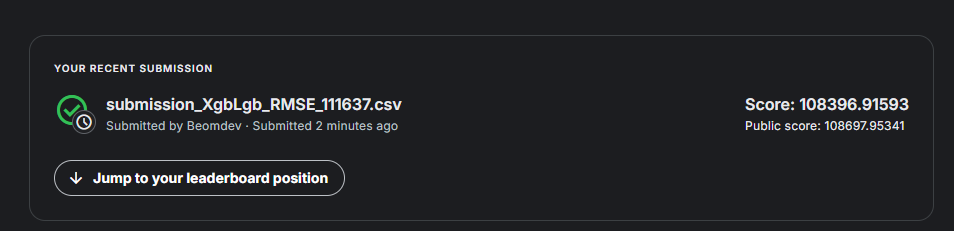